In [105]:
import pandas as pd
import os
import cv2
import numpy as np
from matplotlib import pyplot as plt
from subprocess import call

In [11]:
#!pip3 install pypotrace

### file loading

In [5]:
path = '../data/stylegan'

files = []
# r=root, d=directories, f = files
for r, d, f in os.walk(path):
    for file in f:
        if '.jpg' in file:
            files.append(os.path.join(r, file))


for f in files:
    print(os.path.basename(f))

sample01.jpg
sample02.jpg
sample03.jpg
sample04.jpg


### extract pen paths

In [13]:
def auto_canny(image, sigma=0.33):
    # compute the median of the single channel pixel intensities
    # from here http://www.pyimagesearch.com/2015/04/06/zero-parameter-automatic-canny-edge-detection-with-python-and-opencv/

    v = np.median(image)
 
    # apply automatic Canny edge detection using the computed median
    lower = int(max(0, (1.0 - sigma) * v))
    upper = int(min(255, (1.0 + sigma) * v))
    edge = cv2.Canny(image, lower, upper)
 
    # return the edge image
    return edge

In [68]:
def show_cvimg(img):
    if len(img.shape) > 2:
        img2 = img[:,:,::-1]
        plt.imshow(img2)
    else:
        plt.imshow(img, cmap='gray')

In [69]:
fname = files[0]

(511, 681, 3)


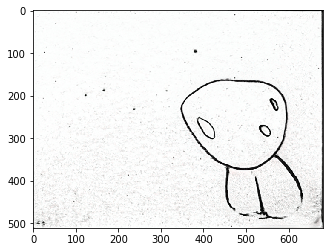

In [127]:
img = cv2.imread(fname)
show_cvimg(img)

In [151]:
# convert to grayscale
gray = np.zeros((img.shape[0], img.shape[1], 1), np.uint8)
edge = np.zeros((img.shape[0], img.shape[1], 1), np.uint8)
blurred = np.zeros((img.shape[0], img.shape[1], 1), np.uint8)

In [152]:
# make greyscale copy of inpnut
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

(511, 681)


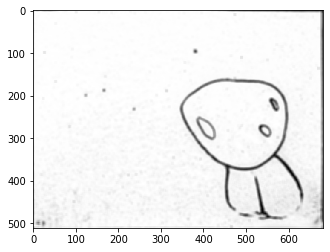

In [153]:
# blur
blurred = cv2.blur(gray, (7,7))
show_cvimg(blurred)

In [154]:
# downsample
newsize = (blurred.shape[1]//2, blurred.shape[0]//2)
resized = cv2.resize(blurred, newsize, interpolation = cv2.INTER_AREA)

(255, 340)


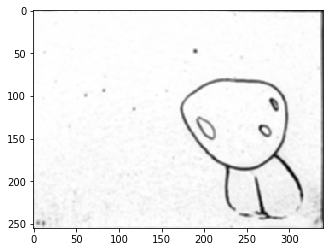

In [155]:
show_cvimg(resized)

In [165]:
# edged = auto_canny(blurred, 0.3)
# edged = auto_canny(blurred, 0.7)
edged = auto_canny(blurred)
# edged = auto_canny(resized)

In [166]:
# edged = cv2.Canny(gray, 50, 200)

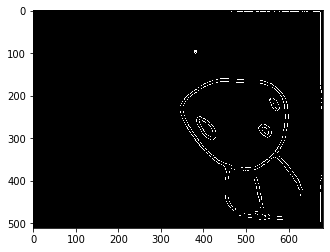

In [167]:
plt.imshow(edged, cmap='gray')

In [168]:
edgefile = "edge.bmp"
cv2.imwrite(edgefile, edged)

True

### connected components

In [169]:
## Find connected edges
ret, labels = cv2.connectedComponents(edge)

In [171]:
colors = [(0, 0, 255), (0, 43, 255), (0, 85, 255), (0, 128, 255), (0, 170, 255), (0, 213, 255), (0, 255, 255), (0, 255, 212), (0, 255, 170), (0, 255, 127), (0, 255, 85), (0, 255, 42), (0, 255, 0), (43, 255, 0), (85, 255, 0), (128, 255, 0), (170, 255, 0), (213, 255, 0), (255, 255, 0), (255, 212, 0), (255, 170, 0), (255, 127, 0), (255, 85, 0), (255, 42, 0), (255, 0, 0)]

## Draw(set to different colors)
canvas = np.zeros_like(img, np.uint8)
for i in range(1,ret):
    pts = labels == i
    canvas[pts] = colors[i%len(colors)]

(511, 681, 3)


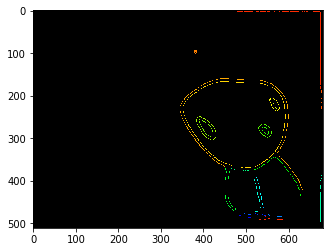

In [172]:
show_cvimg(canvas)

### skeletonize

In [431]:
from skimage.morphology import skeletonize
from skimage.util import invert
from skimage.segmentation import active_contour

In [410]:
block_size = 7

In [411]:
blurred = cv2.medianBlur(resized, block_size)
# blurred = cv2.medianBlur(gray, block_size)

(255, 340)


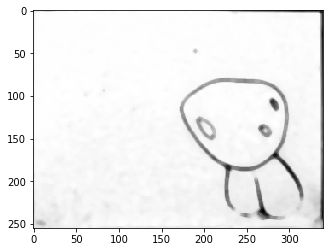

In [412]:
show_cvimg(blurred)

In [413]:
# data = cv2.adaptiveThreshold(blurred,255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C,\
#             cv2.THRESH_BINARY,block_size,11)

In [414]:
data = cv2.adaptiveThreshold(blurred,255,cv2.ADAPTIVE_THRESH_MEAN_C,\
            cv2.THRESH_BINARY,block_size,6)
data = invert(data)

In [415]:
# ret,data = cv2.threshold(blurred,196,255,cv2.THRESH_BINARY_INV)

(255, 340)


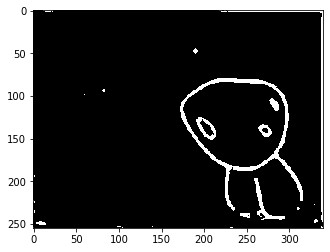

In [416]:
show_cvimg(data)

In [417]:
# data = invert(data)
data[data == 255] = 1
data.shape

(255, 340)

(255, 340)


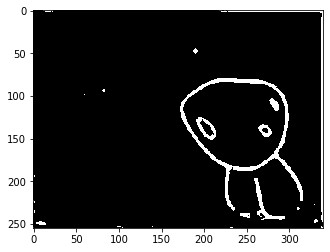

In [418]:
show_cvimg(data)

In [419]:
skeleton = skeletonize(data)
skeleton_lee = skeletonize(data, method='lee')

In [420]:
skeleton.shape

(255, 340)

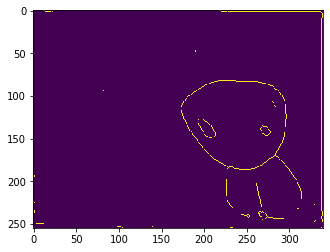

In [421]:
plt.imshow(skeleton_lee)

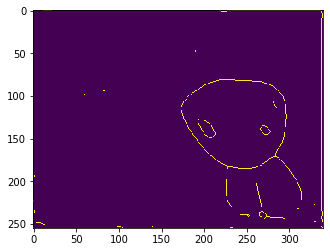

In [422]:
plt.imshow(skeleton)

In [428]:
# Find contours at a constant value of 0.8
r = skeleton
contours = measure.find_contours(r, 0.8)

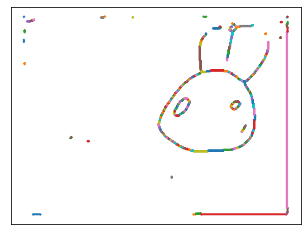

In [430]:
# Display the image and plot all contours found
fig, ax = plt.subplots()
# ax.imshow(r, cmap=plt.cm.gray)

for n, contour in enumerate(contours):
    ax.plot(contour[:, 1], contour[:, 0], linewidth=2)

ax.axis('image')
ax.set_xticks([])
ax.set_yticks([])
plt.show()

### tracing image

In [425]:
potrace = "potrace"
infile = edgefile
width = 8
height = 6
margin = 1
outfile = "traced.svg"
tracecmd = potrace+" {0} -W {1} -H {2} -M {3} -i -a 0 -s -o {4}".format(infile, width, height, margin, outfile)

print(tracecmd)

potrace edge.bmp -W 8 -H 6 -M 1 -i -a 0 -s -o traced.svg


In [426]:
call(tracecmd)

FileNotFoundError: [Errno 2] No such file or directory: 'potrace edge.bmp -W 8 -H 6 -M 1 -i -a 0 -s -o traced.svg': 'potrace edge.bmp -W 8 -H 6 -M 1 -i -a 0 -s -o traced.svg'

### Notes

- https://www.pyimagesearch.com/2019/03/04/holistically-nested-edge-detection-with-opencv-and-deep-learning/